## Model- Gradient Boosted Rregressor (Max-Min feature Scaling)
We train a Gradient boosting Regressor model to perform the task of Time-series forecasting for the monthly average temperature and monthly temperature uncertainity.

I will forecast fixed number of 'Timesteps' (in months) into the future [1 and 12 chosen for current analysis to forecast for next month and next year]. The 'Timesteps' determine how many steps in past we take as input and same number of steps are forecasted in the past. This is an important point to note here because for other machine learning models we will deal with, I will follow the same forecasting.


In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import types
from ibm_botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt

In [7]:
# Importing libraries for training the model and saving it
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import h5py

Initializing random seed.

In [3]:
import random
random.seed(1)

#### Loading Input Data 

In [4]:
def __iter__(self): return 0
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="",
    config=Config(signature_version='oauth'),
    endpoint_url='')

body = client_e.get_object(Bucket='',Key='Global_temperature_final.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

Global_Temp = pd.read_csv(body)
Global_Temp.head()

,Monthly_Uncertainity,Monthly_Temperature,Date
0,1.051,6.704,1850-01-01
1,1.181,8.408,1850-02-01
2,1.102,8.112,1850-03-01
3,0.709,7.332,1850-04-01
4,0.585,7.209,1850-05-01


Convert feature 'Date' to index after converting it into datetime format

In [5]:
Global_Temp['Date']=pd.to_datetime(Global_Temp['Date'])
Global_Temp.set_index('Date',drop=True,inplace=True)

#### Split data into training and testing data set
We will split the data into 3 groups as follows:
1. 80% training
2. 10% validation
3. 10% testing.

In [6]:
Data1,Testing_data=train_test_split(Global_Temp,test_size=0.1,shuffle=False)
Training_data,Validation_data=train_test_split(Data1,test_size=0.11,shuffle=False)

#### Create a function to prepare data for model training or prediction
Take an input time series,

1. 1. Rescale the time-series by performing max-min scaling as follows,

\begin{align}
x_{rescaled} & = \bigg(\frac{x - x_{min}}{x_{max} - x_{min}}\bigg) \\
\end{align}

2. Supervised Learning can be used to perform time-series forecating by taking past steps as input feature and future steps as predicted feature. So, I create a time-seriese matrix of dimension [(length-Timesteps) X (2*Timesteps)] by shifting the original time-series 1 step at a time and adding as column to the matrix. The first half (columnwise) of the matrix is used as input features and then interatively I make prediction on second half of the matrix.

This shifted time-series data matrix is taken by Gradient boosted regressor for training.

In [30]:
def Data_preparation(Data,Timesteps):
    # rescaling
    Data_scaled=(Data-Data.min())/(Data.max()-Data.min())
    # initializing shifted matrix
    ShiftMatrix=pd.DataFrame(columns=np.arange(2*Timesteps))
    for t in range(2*Timesteps):
        ShiftMatrix[t]=Data_scaled.shift(-t) 
    ShiftMatrix.dropna(axis=0,how='any',inplace=True)
    x=ShiftMatrix.loc[:,:Timesteps-1]
    y=ShiftMatrix.loc[:,Timesteps:]
    return x,y

### Model Evaluation
We use two different metrics to evaluate our model

1. Root mean squared error (RMSE). 

\begin{align} 
RMSE & = \sqrt{\bigg(\frac{\Sigma_i^N (y{test}^i-y_{pred}^i)^2}{N}\bigg)} \ 
\end{align}

2. Mean Absolute error (MAE). 

\begin{align} 
MAE & = \bigg(\frac{\Sigma_i^N |y{test}^i-y_{pred}^i|}{N}\bigg) \ 
\end{align}

In [31]:
def Model_evaluation(y,yhat):
    RMSE=np.sqrt(mean_squared_error(np.reshape(y,y.shape[0]*y.shape[1],1),np.reshape(yhat,yhat.shape[0]*yhat.shape[1],1)))
    MAE=mean_absolute_error(np.reshape(y,y.shape[0]*y.shape[1],1),np.reshape(yhat,yhat.shape[0]*yhat.shape[1],1))
    return RMSE, MAE 

### Model-fit-score

To find the best model we compare models for the range of above hyperparameters and two different loss functions namely, 'mean absolute error' and 'mean squared error'. We will find the best set of hyperparameters by estimating the performance metrics on validation data.

#### Hyper-parameters

In [32]:
timesteps=[1,12]
learning_rate_list=np.arange(0.01, 0.21, 0.01)
max_depth_list=np.arange(1,6)

#### Hyperparameter Space Grid Search
I created a function to create Gradient Boosted Regressor Model based on range of hyper-parameters, and then fit it against the training-data set. Next, I create a forecast time-series tensor from validation-data set. Finally, I evaluate the performance by comparing forecasted time-series against the y-validation time-series.

In [33]:
def HP_Eval_Grid(feature,ts):
    RMSE_score=np.zeros((len(learning_rate_list),len(max_depth_list)))
    MAE_score=np.zeros((len(learning_rate_list),len(max_depth_list)))
    x_train,y_train=Data_preparation(Training_data[feature],Timesteps=ts)
    x_valid,y_valid=Data_preparation(Validation_data[feature],Timesteps=ts)
    for l in range(len(learning_rate_list)): 
        for m in range(len(max_depth_list)):
            Model=GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate_list[l],max_depth=max_depth_list[m], loss='ls')        
            y_pred=pd.DataFrame(columns=(ts+np.arange(ts)))
            for t in range(ts):
                Model.fit(x_train,y_train[(t+ts)])
                y_pred[(t+ts)]=Model.predict(x_valid)
            RMSE_score[l,m],MAE_score[l,m]=Model_evaluation(np.array(y_valid),np.array(y_pred))
    return RMSE_score,MAE_score

Lets look at which model will perform the best forecast for both features time-series, namely, 'Monthly_Temperature' and 'Monthly_Uncertainity'.

In [34]:
Temp_Model1=HP_Eval_Grid(feature='Monthly_Temperature',ts=1)
Unc_Model1=HP_Eval_Grid(feature='Monthly_Uncertainity',ts=1)
Temp_Model2=HP_Eval_Grid(feature='Monthly_Temperature',ts=12)
Unc_Model2=HP_Eval_Grid(feature='Monthly_Uncertainity',ts=12)

#### First, plotting performance measure for Models trained on Monthly_Temperature for 1-month forecasting

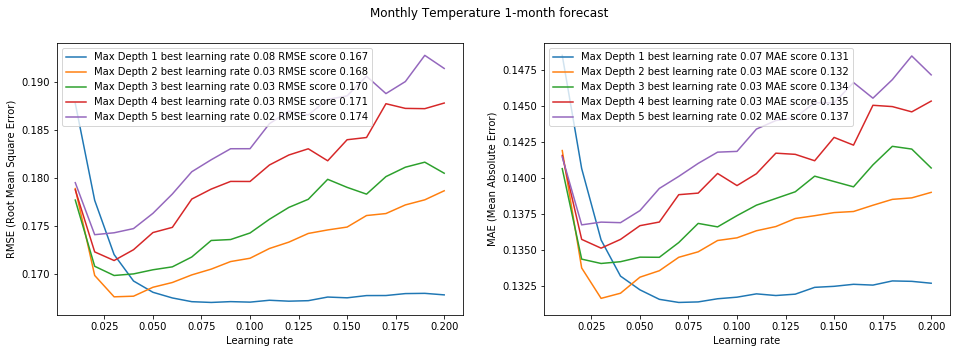

In [35]:
plt.subplots(1,2, figsize=(16, 5))
plt.suptitle('Monthly Temperature 1-month forecast')
plt.subplot(121)
for m in range(len(max_depth_list)):
    plt.plot(learning_rate_list,Temp_Model1[0][:,m],
             label='Max Depth %d best learning rate %.2f RMSE score %.3f'%(max_depth_list[m],
                                                                           learning_rate_list[Temp_Model1[0][:,m].argmin()],Temp_Model1[0][:,m].min()))
    plt.gca().legend()
    plt.xlabel('Learning rate')
    plt.ylabel('RMSE (Root Mean Square Error)')
plt.subplot(122)
for m in range(len(max_depth_list)):
    plt.plot(learning_rate_list,Temp_Model1[1][:,m],
             label='Max Depth %d best learning rate %.2f MAE score %.3f'%(max_depth_list[m],
                                                                          learning_rate_list[Temp_Model1[1][:,m].argmin()],Temp_Model1[1][:,m].min()))
    plt.gca().legend()
    plt.xlabel('Learning rate')
    plt.ylabel('MAE (Mean Absolute Error)')

#### First, plotting performance measure for Models trained on Monthly_Uncertainity for 1-month forecasting

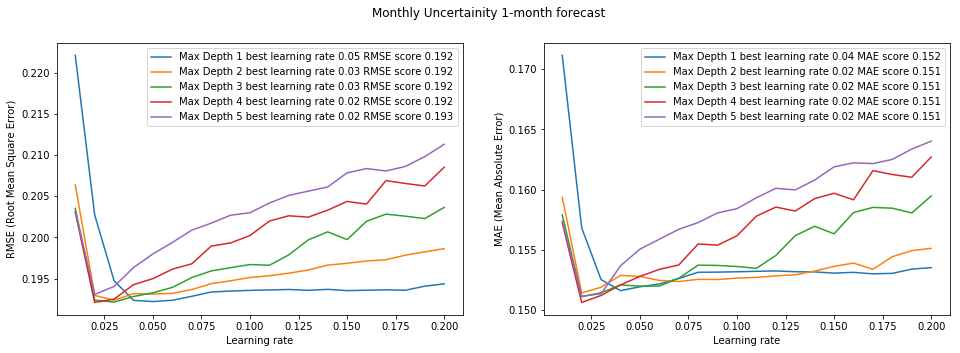

In [36]:
plt.subplots(1,2, figsize=(16, 5))
plt.suptitle('Monthly Uncertainity 1-month forecast')
plt.subplot(121)
for m in range(len(max_depth_list)):
    plt.plot(learning_rate_list,Unc_Model1[0][:,m],
             label='Max Depth %d best learning rate %.2f RMSE score %.3f'%(max_depth_list[m],
                                                                           learning_rate_list[Unc_Model1[0][:,m].argmin()],Unc_Model1[0][:,m].min()))
    plt.gca().legend()
    plt.xlabel('Learning rate')
    plt.ylabel('RMSE (Root Mean Square Error)')
plt.subplot(122)
for m in range(len(max_depth_list)):
    plt.plot(learning_rate_list,Unc_Model1[1][:,m],
             label='Max Depth %d best learning rate %.2f MAE score %.3f'%(max_depth_list[m],
                                                                          learning_rate_list[Unc_Model1[1][:,m].argmin()],Unc_Model1[1][:,m].min()))
    plt.gca().legend()
    plt.xlabel('Learning rate')
    plt.ylabel('MAE (Mean Absolute Error)')

#### First, plotting performance measure for Models trained on Monthly_Temperature for 12-month forecasting

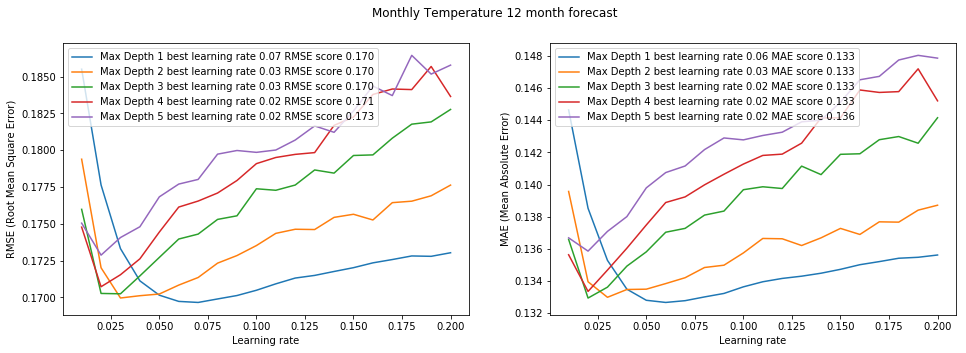

In [37]:
plt.subplots(1,2, figsize=(16, 5))
plt.suptitle('Monthly Temperature 12 month forecast')
plt.subplot(121)
for m in range(len(max_depth_list)):
    plt.plot(learning_rate_list,Temp_Model2[0][:,m],
             label='Max Depth %d best learning rate %.2f RMSE score %.3f'%(max_depth_list[m],
                                                                           learning_rate_list[Temp_Model2[0][:,m].argmin()],Temp_Model2[0][:,m].min()))
    plt.gca().legend()
    plt.xlabel('Learning rate')
    plt.ylabel('RMSE (Root Mean Square Error)')
plt.subplot(122)
for m in range(len(max_depth_list)):
    plt.plot(learning_rate_list,Temp_Model2[1][:,m],
             label='Max Depth %d best learning rate %.2f MAE score %.3f'%(max_depth_list[m],
                                                                          learning_rate_list[Temp_Model2[1][:,m].argmin()],Temp_Model2[1][:,m].min()))
    plt.gca().legend()
    plt.xlabel('Learning rate')
    plt.ylabel('MAE (Mean Absolute Error)')

#### First, plotting performance measure for Models trained on Monthly_Uncertainity for 12-month forecasting

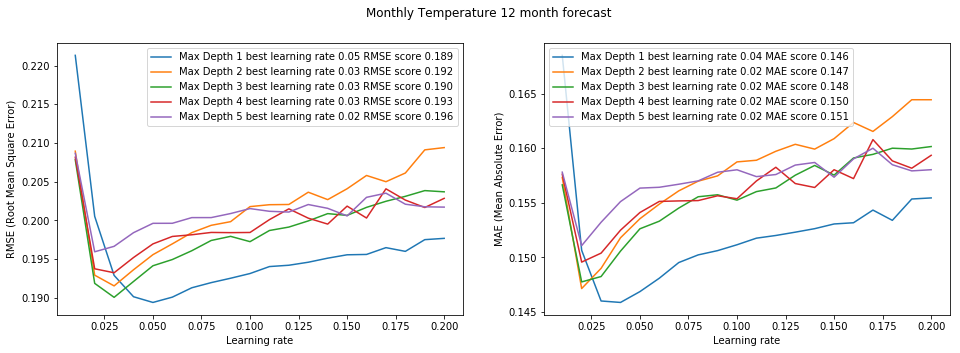

In [38]:
plt.subplots(1,2, figsize=(16, 5))
plt.suptitle('Monthly Temperature 12 month forecast')
plt.subplot(121)
for m in range(len(max_depth_list)):
    plt.plot(learning_rate_list,Unc_Model2[0][:,m],
             label='Max Depth %d best learning rate %.2f RMSE score %.3f'%(max_depth_list[m],
                                                                           learning_rate_list[Unc_Model2[0][:,m].argmin()],Unc_Model2[0][:,m].min()))
    plt.gca().legend()
    plt.xlabel('Learning rate')
    plt.ylabel('RMSE (Root Mean Square Error)')
plt.subplot(122)
for m in range(len(max_depth_list)):
    plt.plot(learning_rate_list,Unc_Model2[1][:,m],
             label='Max Depth %d best learning rate %.2f MAE score %.3f'%(max_depth_list[m],
                                                                          learning_rate_list[Unc_Model2[1][:,m].argmin()],Unc_Model2[1][:,m].min()))
    plt.gca().legend()
    plt.xlabel('Learning rate')
    plt.ylabel('MAE (Mean Absolute Error)')

### Forecast based on Best Model hyper-parameters
Next, I will show the time-series for both features along with the predictions. For this analysis I did not perform Max-Min scaling in the time-series.

It was understandable to see that if forecast timesteps increase we will see a decline in performance. But it's still interesting to try to predict as far into future we can. To that extent, I will show the predicted time series for 1-month and an year (12-months) as forecast timesteps.

**Starting with the simplest of the cases with 'Timesteps=1' which means that we consider history of 1 timestep and predict next timestep.**

Based on the above plots I choose the following model hyper-parameters:

**'Monthy_Temperature':** learning_rate=0.07; max_depth=1

**'Monthy_Uncertainity':** learning_rate=0.02; max_depth=2

In [41]:
ts=1
x_train,y_train=Data_preparation(Training_data['Monthly_Temperature'],Timesteps=ts)
x_test1,y_test1=Data_preparation(Testing_data['Monthly_Temperature'],Timesteps=ts)
Model_temp_ts1=GradientBoostingRegressor(n_estimators=100, learning_rate=0.07,max_depth=1, loss='ls')        
y_pred1=pd.DataFrame(columns=(ts+np.arange(ts)))
for t in range(ts):
    Model_temp_ts1.fit(x_train,y_train[(t+ts)])
    y_pred1[(t+ts)]=Model_temp_ts1.predict(x_test1)
RMSE_score_best1,MAE_score_best1=Model_evaluation(np.array(y_test1),np.array(y_pred1))
x_train,y_train=Data_preparation(Training_data['Monthly_Uncertainity'],Timesteps=ts)
x_test2,y_test2=Data_preparation(Testing_data['Monthly_Uncertainity'],Timesteps=ts)
Model_temp_ts12=GradientBoostingRegressor(n_estimators=100, learning_rate=0.02,max_depth=2, loss='ls')        
y_pred2=pd.DataFrame(columns=(ts+np.arange(ts)))
for t in range(ts):
    Model_temp_ts12.fit(x_train,y_train[(t+ts)])
    y_pred2[(t+ts)]=Model_temp_ts12.predict(x_test2)
RMSE_score_best2,MAE_score_best2=Model_evaluation(np.array(y_test2),np.array(y_pred2))
# scaling back the time-series
y_test1=y_test1*(Testing_data['Monthly_Temperature'].max()-Testing_data['Monthly_Temperature'].min())+Testing_data['Monthly_Temperature'].min()
y_pred1=y_pred1*(Testing_data['Monthly_Temperature'].max()-Testing_data['Monthly_Temperature'].min())+Testing_data['Monthly_Temperature'].min()

Next, let's plot and see how the predicted time-series matchup with the test-data time-series.

Text(0.5,1,'Root Mean Square Error: 0.138 ; Mean Absolute Error: 0.105')

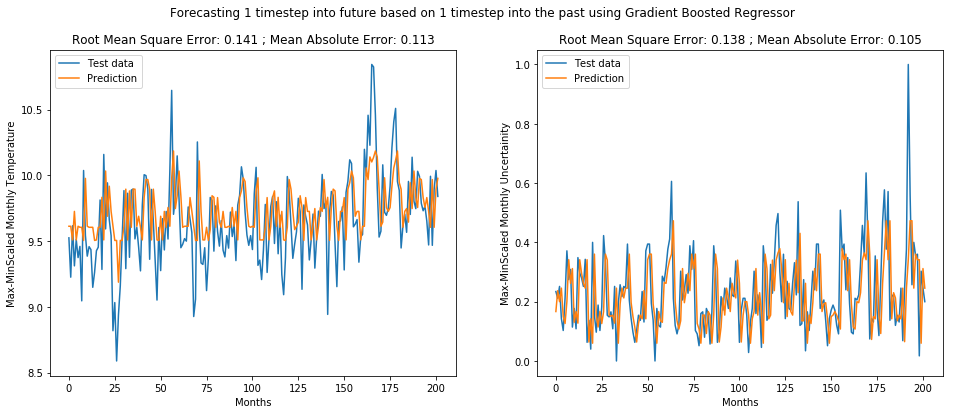

In [42]:
plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Forecasting 1 timestep into future based on 1 timestep into the past using Gradient Boosted Regressor", fontsize="12")
plt.subplot(121)
plt.plot(np.array(y_test1),label="Test data")
plt.plot(np.array(y_pred1),label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Temperature')
plt.title('Root Mean Square Error: %.3f ; Mean Absolute Error: %.3f'% (RMSE_score_best1,MAE_score_best1))
plt.subplot(122)
plt.plot(np.array(y_test2),label="Test data")
plt.plot(np.array(y_pred2),label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Uncertainity')
plt.title('Root Mean Square Error: %.3f ; Mean Absolute Error: %.3f'% (RMSE_score_best2,MAE_score_best2))

**Next I use 'Timesteps=12' so we are using 1-year data to forecast 1-year in future and present the best model forecast along with the performance measure.**

Based on the above plots I choose the following model hyper-parameters:

**'Monthy_Temperature':** learning_rate=0.06; max_depth=1

**'Monthy_Uncertainity':** learning_rate=0.04; max_depth=1

In [43]:
ts=12
x_train,y_train=Data_preparation(Training_data['Monthly_Temperature'],Timesteps=ts)
x_test1,y_test1=Data_preparation(Testing_data['Monthly_Temperature'],Timesteps=ts)
Model_unc_ts1=GradientBoostingRegressor(n_estimators=100, learning_rate=0.06,max_depth=1, loss='ls')        
y_pred1=pd.DataFrame(columns=(ts+np.arange(ts)))
for t in range(ts):
    Model_unc_ts1.fit(x_train,y_train[(t+ts)])
    y_pred1[(t+ts)]=Model_unc_ts1.predict(x_test1)
RMSE_score_best1,MAE_score_best1=Model_evaluation(np.array(y_test1),np.array(y_pred1))
x_train,y_train=Data_preparation(Training_data['Monthly_Uncertainity'],Timesteps=ts)
x_test2,y_test2=Data_preparation(Testing_data['Monthly_Uncertainity'],Timesteps=ts)
Model_unc_ts12=GradientBoostingRegressor(n_estimators=100, learning_rate=0.04,max_depth=1, loss='ls')        
y_pred2=pd.DataFrame(columns=(ts+np.arange(ts)))
for t in range(ts):
    Model_unc_ts12.fit(x_train,y_train[(t+ts)])
    y_pred2[(t+ts)]=Model_unc_ts12.predict(x_test2)
RMSE_score_best2,MAE_score_best2=Model_evaluation(np.array(y_test2),np.array(y_pred2))
# scaling back the time-series
y_test1=y_test1*(Testing_data['Monthly_Temperature'].max()-Testing_data['Monthly_Temperature'].min())+Testing_data['Monthly_Temperature'].min()
y_pred1=y_pred1*(Testing_data['Monthly_Temperature'].max()-Testing_data['Monthly_Temperature'].min())+Testing_data['Monthly_Temperature'].min()
y_test1=np.array(y_test1)
y_pred1=np.array(y_pred1)
y_test2=np.array(y_test2)
y_pred2=np.array(y_pred2)

To see how good is the forecast I plotted the average difference between the yearly predicted data and test-data at each timepoint.

Text(0.5,1,'Root Mean Square Error: 0.122 ; Mean Absolute Error: 0.094')

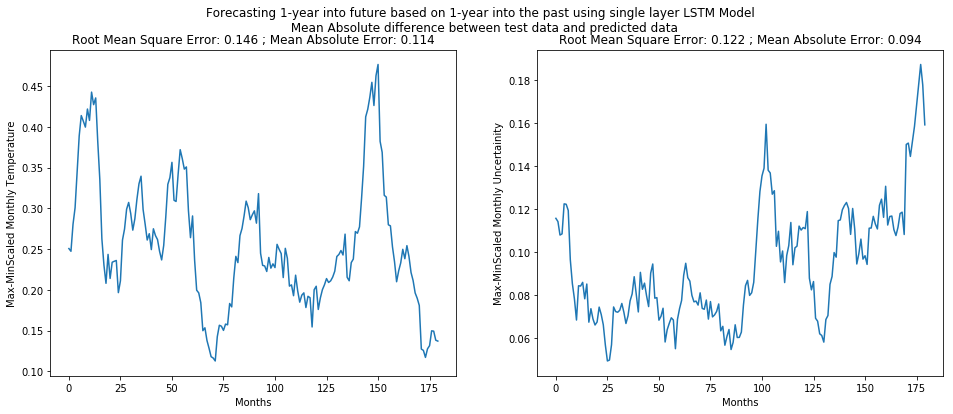

In [44]:
plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Forecasting 1-year into future based on 1-year into the past using single layer LSTM Model \n Mean Absolute difference between test data and predicted data", fontsize="12")
plt.subplot(121)
plt.plot(np.mean(abs(y_test1-y_pred1),axis=1))
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Temperature')
plt.title('Root Mean Square Error: %.3f ; Mean Absolute Error: %.3f'% (RMSE_score_best1,MAE_score_best1))
plt.subplot(122)
plt.plot(np.mean(abs(y_test2-y_pred2),axis=1))
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Uncertainity')
plt.title('Root Mean Square Error: %.3f ; Mean Absolute Error: %.3f'% (RMSE_score_best2,MAE_score_best2))

Here we can see that at certain time-points the forecast is much better than the others. I show cases when the forecast was the best and the worst.

In [45]:
best_temp_pred_month=np.mean(abs(y_test1-y_pred1),axis=1).argmin()
Worst_temp_pred_month=np.mean(abs(y_test1-y_pred1),axis=1).argmax()
best_unc_pred_month=np.mean(abs(y_test2-y_pred2),axis=1).argmin()
Worst_unc_pred_month=np.mean(abs(y_test2-y_pred2),axis=1).argmax()

Text(0.5,1,'Mean Absolute Error: 0.187')

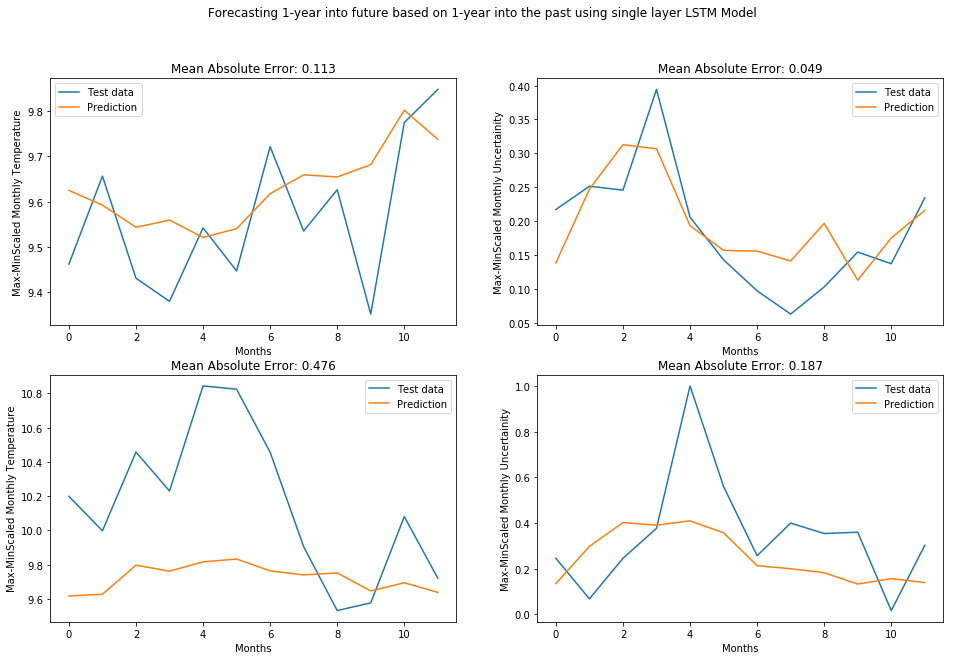

In [46]:
plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Forecasting 1-year into future based on 1-year into the past using single layer LSTM Model", fontsize="12")
plt.subplot(221)
plt.plot(y_test1[best_temp_pred_month],label="Test data")
plt.plot(y_pred1[best_temp_pred_month],label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Temperature')
plt.title('Mean Absolute Error: %.3f'% np.mean(abs(y_test1-y_pred1),axis=1).min())
plt.subplot(222)
plt.plot(y_test2[best_unc_pred_month],label="Test data")
plt.plot(y_pred2[best_unc_pred_month],label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Uncertainity')
plt.title('Mean Absolute Error: %.3f'% np.mean(abs(y_test2-y_pred2),axis=1).min())
plt.subplot(223)
plt.plot(y_test1[Worst_temp_pred_month],label="Test data")
plt.plot(y_pred1[Worst_temp_pred_month],label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Temperature')
plt.title('Mean Absolute Error: %.3f'% np.mean(abs(y_test1-y_pred1),axis=1).max())
plt.subplot(224)
plt.plot(y_test2[Worst_unc_pred_month],label="Test data")
plt.plot(y_pred2[Worst_unc_pred_month],label="Prediction")
plt.gca().legend()
plt.xlabel('Months')
plt.ylabel('Max-MinScaled Monthly Uncertainity')
plt.title('Mean Absolute Error: %.3f'% np.mean(abs(y_test2-y_pred2),axis=1).max())